## Modeling
### Experiments with XGBoost for Forecasting Stocks

**Objetivo**: O objetivo deste notebook é fazer experimentos de modelagem com o modelo XGBoost, que será construido de forma iterativa (1 step-ahead forecast)



**Conclusões**:


### 1.0 Imports

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
#from pandas_profiling import ProfileReport

# Time Series Libraries
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  #Autocorrelação (MA), Autocorrelatcao parcial (AR)ve
from pmdarima.arima.utils import ndiffs 

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb

from scipy.stats import shapiro, normaltest, kstest

import mlflow

### 2.0 Definindo Parâmetros

In [17]:
model_config = {
    "TEST_SIZE": 0.2,
    "TARGET_NAME": "Close",
    "VALIDATION_METRIC": "MAPE",
    "OPTIMIZATION_METRIC": "MSE",
    "FORECAST_HORIZON": 10,
    "REGISTER_MODEL_NAME": "Stock_Predictor"
}
run_name = "Experiment_run"

# Define a ação para procurar
STOCK_NAME = 'BOVA11.SA'

### 3.0 Criando Funções

In [3]:
def build_features(raw_df: pd.DataFrame, features_list: list) -> pd.DataFrame:
    """
    This function creates the features for the dataset to be consumed by the
    model
    
    :param raw_df: Raw Pandas DataFrame to create the features of
    :param features_list: The list of features to create

    :return: Pandas DataFrame with the new features
    """

    stock_df_featurized = raw_df.copy()
    for feature in features_list:
        
        # Create "Time" features]
        if feature == "day_of_month":
            stock_df_featurized['day_of_month'] = stock_df_featurized["Date"].apply(lambda x: x.day)
        elif feature == "month":
            stock_df_featurized['month'] = stock_df_featurized['Date'].apply(lambda x: x.month)
        elif feature == "quarter":
            stock_df_featurized['quarter'] = stock_df_featurized['Date'].apply(lambda x: x.quarter)

    # Create "Lag" features
    # The lag 1 feature will become the main regressor, and the regular "Close" will become the target.
    # As we saw that the lag 1 holds the most aucorrelation, it is reasonable to use it as the main regressor.
        elif feature == "Close_lag_1":
            stock_df_featurized['Close_lag_1'] = stock_df_featurized['Close'].shift()


    # Drop nan values because of the shift
    stock_df_featurized = stock_df_featurized.dropna()
    # Drop the Date column
    #stock_df_featurized = stock_df_featurized.drop("Date", axis=1)
    # Save the dataset
    stock_df_featurized.to_csv("../data/processed/processed_stock_prices.csv", index=False)

    return stock_df_featurized


In [4]:
def ts_train_test_split(data, target, test_size):
    train_df = data.iloc[:-test_size, :]
    test_df = data.iloc[-test_size:, :]
    X_train = train_df.drop(target, axis=1)
    y_train = train_df[target]
    X_test = test_df.drop(target, axis=1)
    y_test = test_df[target]

    return X_train, X_test, y_train, y_test

In [5]:
def visualize_validation_results(pred_df, model_mape, model_rmse):

    """
    Creates visualizations of the model training and validation
    """

    # Transform predictions into dataframe
    

    fig, axs = plt.subplots(figsize=(12, 5))
    # Plot the Actuals
    sns.lineplot(
        data=pred_df,
        x="Date",
        y="Actual",
        label="Testing values",
        ax=axs
    )
    sns.scatterplot(
        data=pred_df,
        x="Date",
        y="Actual",
        ax=axs,
        size="Actual",
        sizes=(80, 80), legend=False
    )

    # Plot the Forecasts
    sns.lineplot(
        data=pred_df,
        x="Date",
        y="Forecast",
        label="Forecast values",
        ax=axs
    )
    sns.scatterplot(
        data=pred_df,
        x="Date",
        y="Forecast",
        ax=axs,
        size="Forecast",
        sizes=(80, 80), legend=False
    )

    axs.set_title(f"Default XGBoost {model_config['FORECAST_HORIZON']} days Forecast for {STOCK_NAME}\nMAPE: {round(model_mape*100, 2)}% | RMSE: R${model_rmse}")
    axs.set_xlabel("Date")
    axs.set_ylabel("R$")

    plt.savefig(f"../reports/figures/XGBoost_predictions_{dt.datetime.now()}.png")


In [6]:
def validate_model(model, X_val):
    """
    Perform predictions to validate the model
    
    :param model: The Fitted model
    :param X_val: Validation Features
    :Param y_val: Validation Target
    """

    prediction = model.predict(X_val)

    return prediction



In [15]:
def train_model(X_train, y_train, random_state=42):
    """
    Trains a XGBoost model for Forecasting
    
    :param X_train: Training Features
    :param y_train: Training Target

    :return: Fitted model
    """
    

    with mlflow.start_run(run_name=run_name) as run:
        # create the model
        xgboost_model = xgb.XGBRegressor(
            random_state=random_state,
            )

        # train the model
        xgboost_model.fit(
            X_train,
            y_train, 
            )

         # get the run id
        model_uri = f"runs:/{run.info.run_id}/{model_config['REGISTER_MODEL_NAME']}_{run_name}"

        # log the model
        model_signature = mlflow.models.signature.infer_signature(X_train, pd.DataFrame(y_train))

        mlflow.sklearn.log_model(
            xgboost_model,
            "first_xgboost",
            input_example=X_train.head(),
            signature=model_signature
        )

        # register the model
        model_details = mlflow.register_model(
            model_uri = model_uri,
            name = model_config['REGISTER_MODEL_NAME']
        )


        # set model to staging version to be tested
        client = mlflow.MlflowClient()

        client.transition_model_version_stage(
            name=model_config["REGISTER_MODEL_NAME"],
            version=model_details.version,
            stage="Staging"
        )


        
    return xgboost_model


In [19]:
def make_in_sample_predictions(X, y, forecast_horizon):
    """
    Iterate over forecast horizon performing
    stepwise iterative predictions
    """

    # Create empty list for storing each prediction
    predictions = []
    actuals = []
    dates = []


    # Iterate over the dataset to perform predictions over the forecast horizon, one by one.
    # So we need to start at training = training until the total forecast horizon, then, perform the next step
    # After forecasting the next step, we need to append the new line to the training dataset and so on

    for day in range(forecast_horizon, 0, -1):

        # update the training and testing sets
        X_train = X.iloc[:-day, :]
        y_train = y.iloc[:-day]
        print("Training until", X_train["Date"].max())
        # we need to change the syntax if this the last day
        if day != 1:
            # the testing set will be the next day after the training
            X_test = X.iloc[-day:-day+1,:]
            y_test = y.iloc[-day:-day+1]

        else:
            # need to change the syntax for the last day (for -1:-2 will not work)
            X_test = X.iloc[-day:,:]
            y_test = y.iloc[-day:]

        # train the model
        xgboost_model = train_model(X_train.drop("Date", axis=1), y_train)

        # make prediction
        prediction = validate_model(xgboost_model, X_test.drop("Date", axis=1))
        
        # store the results
        predictions.append(prediction[0])
        actuals.append(y_test.values[0])
        dates.append(X_test["Date"].max())

    
    # Calculate the resulting metric
    model_mape = round(mean_absolute_percentage_error(actuals, predictions), 4)
    print(model_mape)
    model_rmse = round(np.sqrt(mean_squared_error(actuals, predictions)), 2)

In [9]:
def make_out_of_sample_predictions(X, y, forecast_horizon):
    """
    Make predictions for the next `forecast_horizon` days using a XGBoost model
    
    Parameters:
        X (pandas dataframe): The input data
        y (pandas dataframe): The target data
        forecast_horizon (int): Number of days to forecast
        
    Returns:
        None
    """

    # Create empty list for storing each prediction
    predictions = []
    actuals = []
    dates = []

    # Iterate over the dataset to perform predictions over the forecast horizon, one by one.
    # So we need to start at training = training until the total forecast horizon, then, perform the next step
    # After forecasting the next step, we need to append the new line to the training dataset and so on

    for day in range(forecast_horizon, 0, -1):

        # update the training and testing sets
        X_train = X.iloc[:-day, :]
        y_train = y.iloc[:-day]
 
        if day != 1:
            # the testing set will be the next day after the training
            X_test = X.iloc[-day:-day+1,:]
            y_test = y.iloc[-day:-day+1]

        else:
            # need to change the syntax for the last day (for -1:-2 will not work)
            X_test = X.iloc[-day:,:]
            y_test = y.iloc[-day:]

        # only the first iteration will use the true value of y_train
        # because the following ones will use the last predicted value as true value
        # so we simulate the process of predicting out-of-sample
        if len(predictions) != 0:
            # update the y_train with the last predictions
            y_train.iloc[-len(predictions):] = predictions[-len(predictions):]

            # now update the Close_lag_1 feature, remember -1 is the position of this column
            X_train.iloc[-len(predictions):, -1] = y_train.shift(1).iloc[-len(predictions):]
            X_train = X_train.dropna()

        else:
            pass
        
        # train the model
        xgboost_model = train_model(X_train.drop("Date", axis=1), y_train)

        # make prediction
        prediction = xgboost_model.predict(X_test.drop("Date", axis=1))

        # store the results
        predictions.append(prediction[0])
        actuals.append(y_test.values[0])
        dates.append(X_test["Date"].max())

    # Calculate the resulting metric
    model_mape = round(mean_absolute_percentage_error(actuals, predictions), 4)
    model_rmse = round(np.sqrt(mean_squared_error(actuals, predictions)), 2)
 
    pred_df = pd.DataFrame(list(zip(dates, actuals, predictions)), columns=["Date", 'Actual', 'Forecast'])
    visualize_validation_results(pred_df, model_mape, model_rmse)

    return pred_df

### 4.0 Executando

/home/michel/anaconda3/envs/datascience/lib/python3.8/site-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/home/michel/anaconda3/envs/datascience/lib/python3.8/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distu

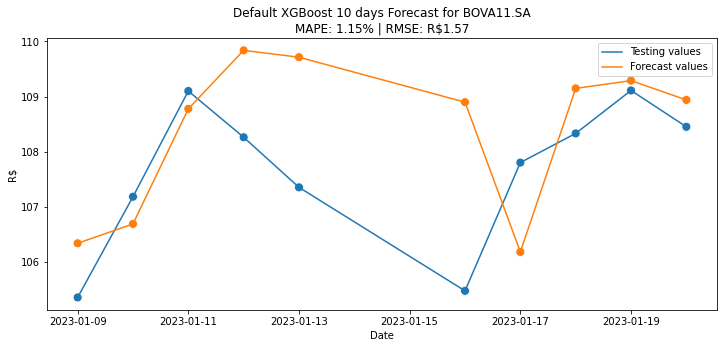

In [18]:
# Load the raw dataset
stock_df = pd.read_csv('../data/raw/raw_stock_prices.csv', parse_dates=True)
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

# Perform featurization
features_list = ["day_of_month", "month", "quarter", "Close_lag_1"]

stock_df_feat = build_features(stock_df, features_list)

# train test split
X_train, X_test, y_train, y_test = ts_train_test_split(stock_df_feat, model_config["TARGET_NAME"], model_config["FORECAST_HORIZON"])


# Execute the whole pipeline
predictions_df = make_out_of_sample_predictions(pd.concat([X_train, X_test], axis=0), pd.concat([y_train, y_test], axis=0), model_config['FORECAST_HORIZON'])